In [160]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import acquire
import prepare

from importlib import reload

# Excercises: Exploratory Analysis
> * Do your work for this exercise in a notebook named explore. 
> * Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.
> * For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. 
> * For both datasets you should choose a method of splitting your data and only explore the training split.

# Store Item Demand Data

In [5]:
reload(prepare)

<module 'prepare' from '/Users/sinao/codeup-data-science/time-series-exercises/prepare.py'>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sale_amount    913000 non-null  float64
 1   item_brand     913000 non-null  object 
 2   item_name      913000 non-null  object 
 3   item_price     913000 non-null  float64
 4   item_upc12     913000 non-null  object 
 5   item_upc14     913000 non-null  object 
 6   store_address  913000 non-null  object 
 7   store_city     913000 non-null  object 
 8   store_state    913000 non-null  object 
 9   store_zipcode  913000 non-null  object 
 10  month          913000 non-null  object 
 11  day of week    913000 non-null  object 
 12  sales_total    913000 non-null  float64
dtypes: float64(3), object(10)
memory usage: 97.5+ MB

        Info: None

        Nulls:
sale_amount      0
item_brand       0
item_name        0
item_price       0
item_upc12       0
item_upc14   

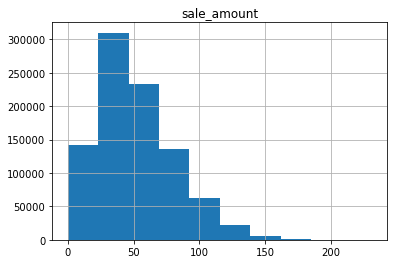

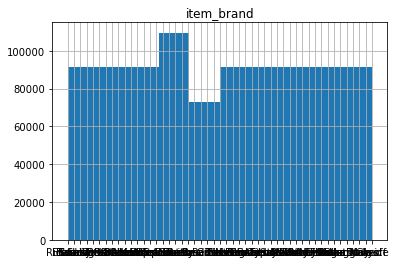

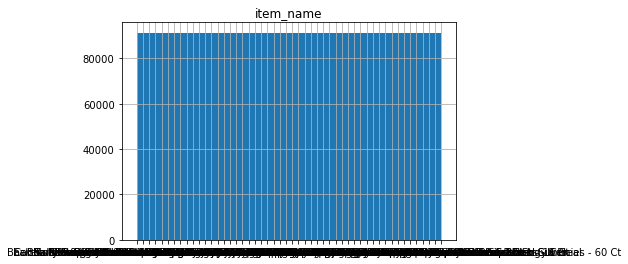

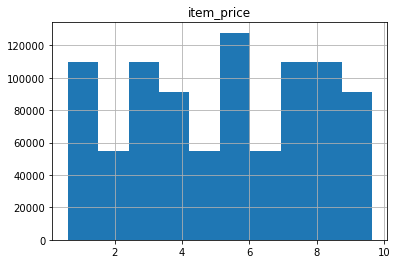

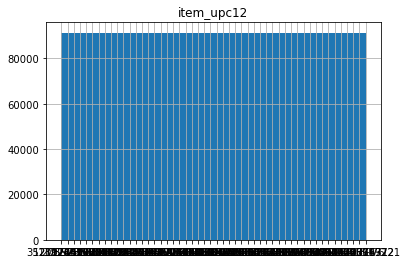

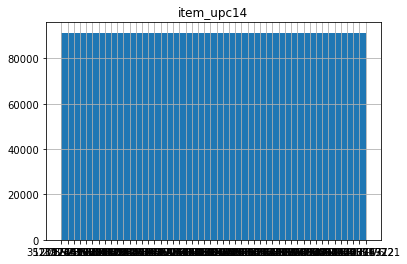

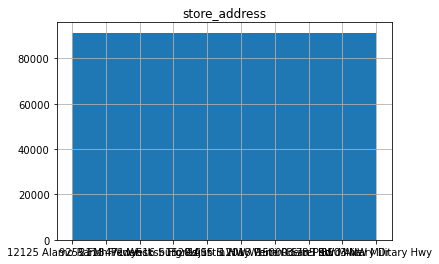

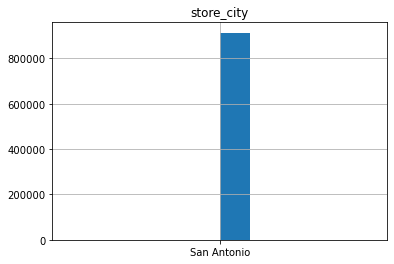

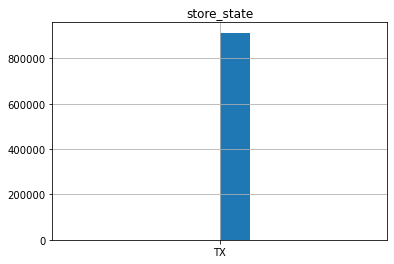

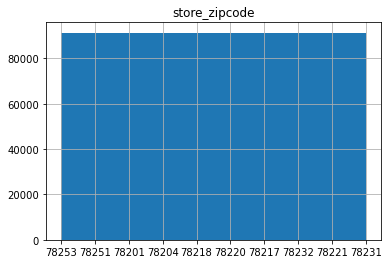

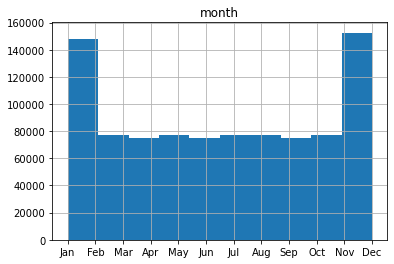

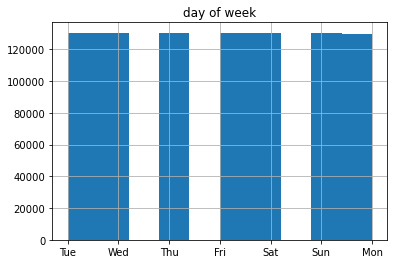

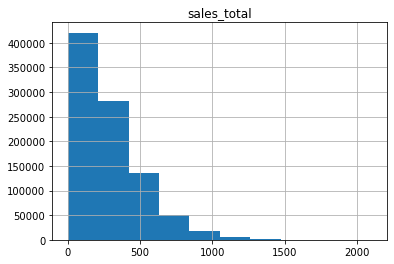

In [6]:
sales = acquire.acquire_all_data()
sales = prepare.prepare(sales)

### Takeaways
* Can drop `sale_id`, `store_id`, `item_id` 
    - backport to `prepare.py` **completed

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sale_amount    913000 non-null  float64
 1   item_brand     913000 non-null  object 
 2   item_name      913000 non-null  object 
 3   item_price     913000 non-null  float64
 4   item_upc12     913000 non-null  object 
 5   item_upc14     913000 non-null  object 
 6   store_address  913000 non-null  object 
 7   store_city     913000 non-null  object 
 8   store_state    913000 non-null  object 
 9   store_zipcode  913000 non-null  object 
 10  month          913000 non-null  object 
 11  day of week    913000 non-null  object 
 12  sales_total    913000 non-null  float64
dtypes: float64(3), object(10)
memory usage: 129.8+ MB


In [8]:
#code ported to prepare.py
#sales = sales.drop(columns=['sale_id', 'store_id', 'item_id'])

## Data Splitting

In [106]:
sales = sales.resample('D').sum()

<AxesSubplot:xlabel='sale_date'>

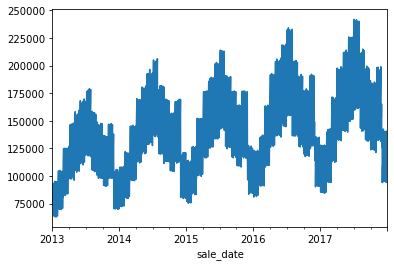

In [107]:
#decide human based or percentage based
# visualize data first over time. target is sale_amount
sales.sales_total.plot()

### Takeaways
* appears to have yearly seasonality with peaks towards center of year. 
* trending upwards over the long term
* will use **human-based** split 

In [108]:
#use loc. frame slicing with single string is going to be deprecated
test_sales = sales.loc['2017']

#loc slice is inclusive
train_sales = sales.loc[:'2016']

<AxesSubplot:xlabel='sale_date'>

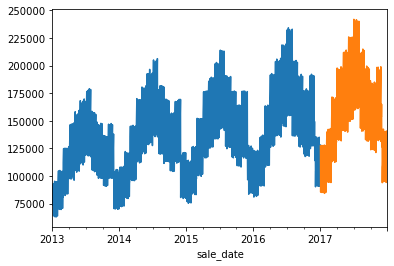

In [109]:
train_sales.sales_total.plot()
test_sales.sales_total.plot()


## Takeaways
* Need to find out how to properly graph
* resampled daily, lost some information and not really sure what to do about that

## Visualizations - Non-Time Series

In [110]:
#store variable for easier access
y = train_sales.sales_total
y.head()

sale_date
2013-01-01    73844.01
2013-01-02    73570.58
2013-01-03    78169.48
2013-01-04    84467.73
2013-01-05    87621.85
Freq: D, Name: sales_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

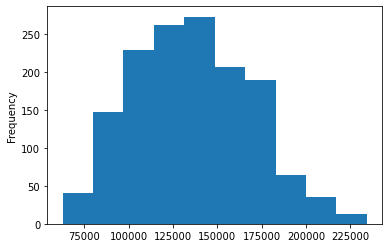

In [111]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Daily Revenue by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Revenue')]

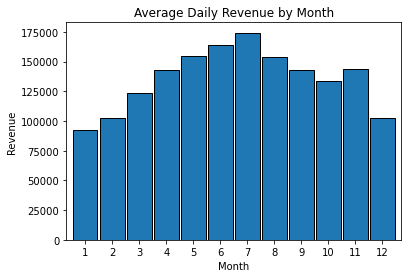

In [117]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Daily Revenue by Month', xlabel='Month', ylabel='Revenue')

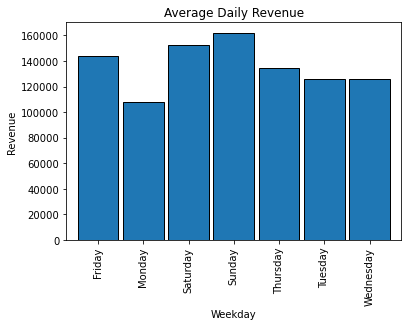

In [126]:
ax = y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
ax.set(title='Average Daily Revenue', xlabel='Weekday', ylabel='Revenue')
plt.show()


In [194]:
# y.reset_index()\
#     .assign(weekday=lambda df: df.datetime.dt.day_name())\
#     .pipe((sns.boxplot, 'data'), y='temp', x='weekday')

## Takeaways
* histogram looks normally distributed
* weekends have most money spent

## Target Over time

<AxesSubplot:xlabel='sale_date'>

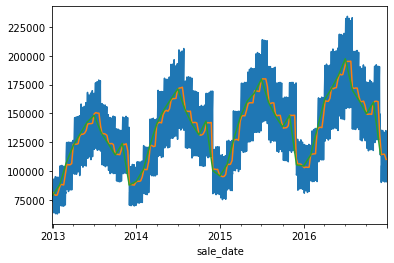

In [129]:
y.resample('D').mean().plot()
y.resample('W').mean().plot()
y.resample('M').mean().plot()

## Changes over time

<AxesSubplot:title={'center':'Average week-to-week change in revenue'}, xlabel='sale_date'>

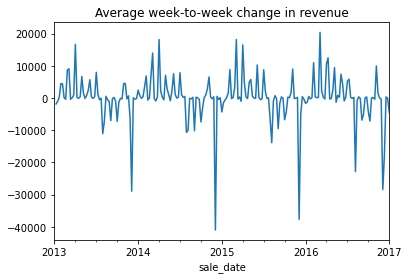

In [130]:
#using the .diff method
y.resample('W').mean().diff()\
    .plot(title='Average week-to-week change in revenue')

<AxesSubplot:title={'center':'Average week-to-week change in revenue'}, xlabel='sale_date'>

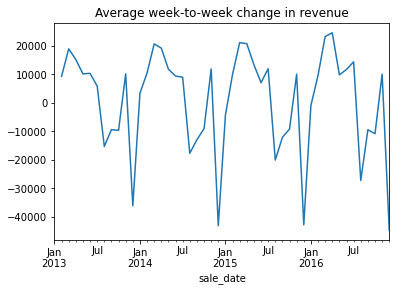

In [131]:
#using the .diff method
y.resample('M').mean().diff()\
    .plot(title='Average month-to-month change in revenue')

## Seasonal Plot

<AxesSubplot:title={'center':'Seasonal'}, xlabel='sale_date'>

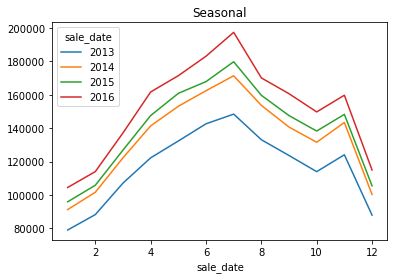

In [132]:
y.groupby([y.index.year, y.index.month]).mean()\
    .unstack(0)\
    .plot(title='Seasonal')

## Seasonal Subseries Plot

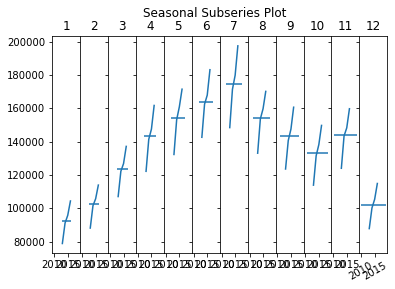

In [137]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.items()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    plt.xticks(rotation=30)


fig.suptitle('Seasonal Subseries Plot')
fig.subplots_adjust(wspace=0)

## Lag Plot

Text(0.5, 1.0, 'Lag plot with lag=1')

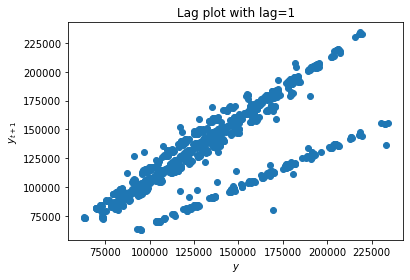

In [138]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

In [140]:
#too make colomn that is 'next day'
train_sales['y(t + 1)'] = train_sales.sales_total.shift(-1)
train_sales['y(t + 1)']

/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_5357/2945196696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sales['y(t + 1)'] = train_sales.sales_total.shift(-1)


In [142]:
del train_sales['y(t + 1)']

In [148]:
train_sales

,sale_amount,item_price,sales_total
sale_date,,,
2013-01-01,13696.0,2580.2,73844.01
2013-01-02,13678.0,2580.2,73570.58
2013-01-03,14488.0,2580.2,78169.48
2013-01-04,15677.0,2580.2,84467.73
2013-01-05,16237.0,2580.2,87621.85
...,...,...,...
2016-12-27,19341.0,2580.2,103657.89
2016-12-28,19560.0,2580.2,105313.94
2016-12-29,21111.0,2580.2,113221.85


In [146]:
#next week column
#using mean takes the average over that timeframe. please remember this. 
#train_sales.resample('W').mean()

,sale_amount,item_price,sales_total
sale_date,,,
2013-01-06,15177.833333,2580.2,81794.583333
2013-01-13,14843.142857,2580.2,79990.601429
2013-01-20,14707.142857,2580.2,78973.360000
2013-01-27,14756.857143,2580.2,79272.691429
2013-02-03,15575.285714,2580.2,83792.507143
...,...,...,...
2016-12-04,24508.428571,2580.2,131884.498571
2016-12-11,21309.285714,2580.2,114279.947143
2016-12-18,21341.142857,2580.2,114649.321429


,sale_amount,item_price,this_week,next_week
sale_date,,,,
2013-01-06,91067.0,15481.2,490767.50,559934.21
2013-01-13,103902.0,18061.4,559934.21,552813.52
2013-01-20,102950.0,18061.4,552813.52,554908.84
2013-01-27,103298.0,18061.4,554908.84,586547.55
2013-02-03,109027.0,18061.4,586547.55,617594.61
...,...,...,...,...
2016-12-04,171559.0,18061.4,923191.49,799959.63
2016-12-11,149165.0,18061.4,799959.63,802545.25
2016-12-18,149388.0,18061.4,802545.25,802308.50


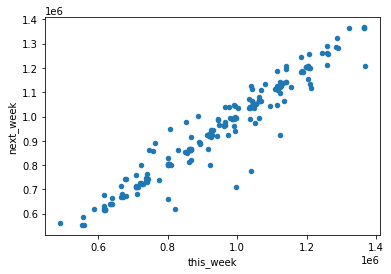

In [149]:
weekly = train_sales.resample('W').sum()
weekly['next_week'] = weekly.sales_total.shift(-1)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='next_week')
weekly

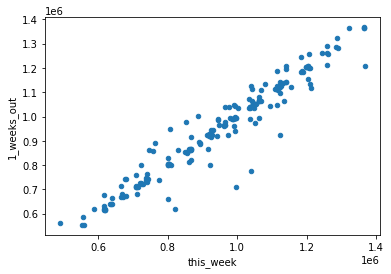

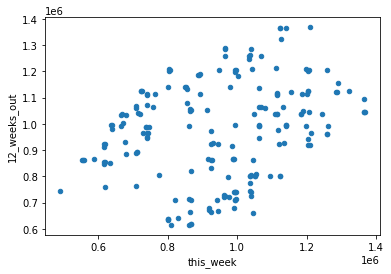

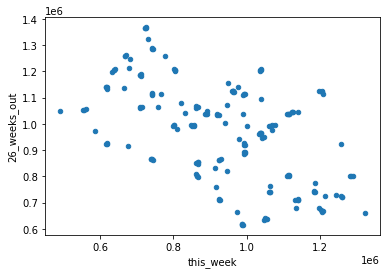

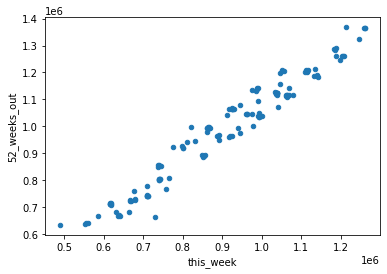

In [153]:
## twelve weeks out
# weekly['12_weeks_out'] = weekly.sales_total.shift(-12)
# weekly.plot.scatter('this_week', '12_weeks_out')

num_of_weeks = [1, 12, 26, 52]

for num in num_of_weeks:
    weekly[f'{num}_weeks_out'] = weekly.this_week.shift(-num) 
    weekly.plot.scatter('this_week', f'{num}_weeks_out')


In [156]:
weekly.corr()

,sale_amount,item_price,this_week,next_week,1_weeks_out,12_weeks_out,26_weeks_out,52_weeks_out
sale_amount,1.000000,0.188195,0.999987,0.965396,0.965396,0.252197,-0.545575,0.976544
item_price,0.188195,1.000000,0.187990,0.140877,0.140877,0.087902,-0.028298,0.153058
this_week,0.999987,0.187990,1.000000,0.965468,0.965468,0.252425,-0.545700,0.976601
next_week,0.965396,0.140877,0.965468,1.000000,1.000000,0.324750,-0.529126,0.931797
1_weeks_out,0.965396,0.140877,0.965468,1.000000,1.000000,0.324750,-0.529126,0.931797
12_weeks_out,0.252197,0.087902,0.252425,0.324750,0.324750,1.000000,0.077683,0.084934
26_weeks_out,-0.545575,-0.028298,-0.545700,-0.529126,-0.529126,0.077683,1.000000,-0.669874
52_weeks_out,0.976544,0.153058,0.976601,0.931797,0.931797,0.084934,-0.669874,1.000000


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

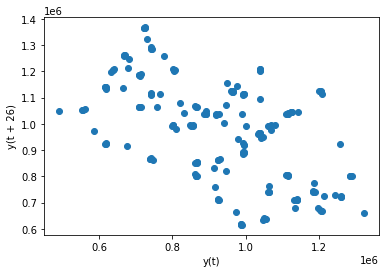

In [155]:
#pandas built in lag plot in leiu of creating columns
pd.plotting.lag_plot(weekly.this_week, lag=26)

## Autocorrelation Plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

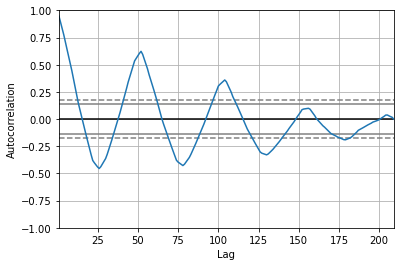

In [157]:
pd.plotting.autocorrelation_plot(weekly.this_week)

## Seasonal Decomposition

In [163]:
weekly

,sale_amount,item_price,this_week,next_week,1_weeks_out,12_weeks_out,26_weeks_out,52_weeks_out
sale_date,,,,,,,,
2013-01-06,91067.0,15481.2,490767.50,559934.21,559934.21,745509.32,1047232.88,632614.72
2013-01-13,103902.0,18061.4,559934.21,552813.52,552813.52,862355.48,1055525.97,638402.82
2013-01-20,102950.0,18061.4,552813.52,554908.84,554908.84,864014.80,1051977.97,637813.88
2013-01-27,103298.0,18061.4,554908.84,586547.55,586547.55,863415.30,1051695.86,640576.34
2013-02-03,109027.0,18061.4,586547.55,617594.61,617594.61,866537.80,974316.90,665173.38
...,...,...,...,...,...,...,...,...
2016-12-04,171559.0,18061.4,923191.49,799959.63,799959.63,NaN,NaN,NaN
2016-12-11,149165.0,18061.4,799959.63,802545.25,802545.25,NaN,NaN,NaN
2016-12-18,149388.0,18061.4,802545.25,802308.50,802308.50,NaN,NaN,NaN


In [213]:
y_weekly = weekly.this_week

result = sm.tsa.seasonal_decompose(y_weekly)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal, 
    'resid': result.resid,
})

decomposition.head()

,y,trend,seasonal,resid
sale_date,,,,
2013-01-06,490767.50,NaN,-271030.635847,NaN
2013-01-13,559934.21,NaN,-277299.023892,NaN
2013-01-20,552813.52,NaN,-279673.865430,NaN
2013-01-27,554908.84,NaN,-280916.622674,NaN
2013-02-03,586547.55,NaN,-270743.295366,NaN


<AxesSubplot:xlabel='sale_date'>

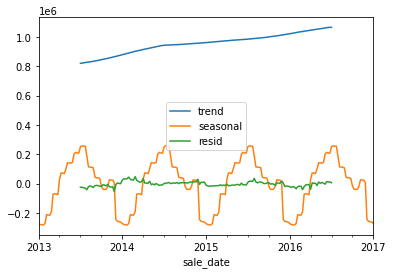

In [214]:
decomposition.iloc[:, 1:].plot()

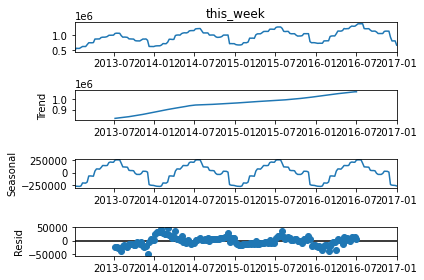

In [215]:
result.plot()
None

## Categories Over Time 
* N/A for sales

# OPSD Data

In [165]:
opsd = acquire.acquire_energy()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4383 non-null   float64
 1   Wind         4383 non-null   float64
 2   Solar        4383 non-null   float64
 3   Wind+Solar   4383 non-null   float64
 4   month        4383 non-null   object 
 5   year         4383 non-null   object 
dtypes: float64(4), object(2)
memory usage: 239.7+ KB

        None
        Nulls:
Consumption    0
Wind           0
Solar          0
Wind+Solar     0
month          0
year           0
dtype: int64

        


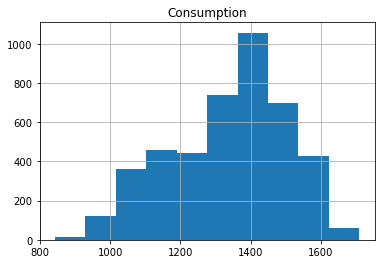

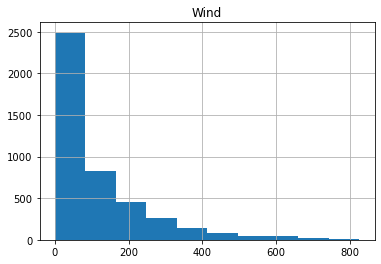

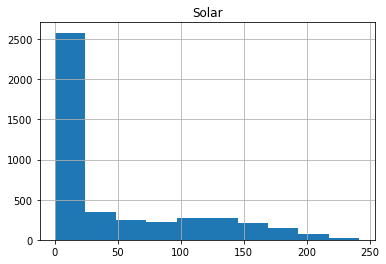

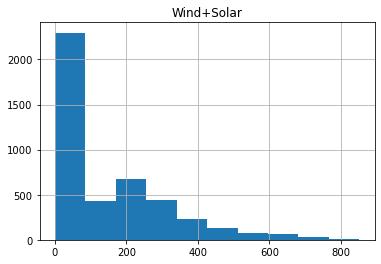

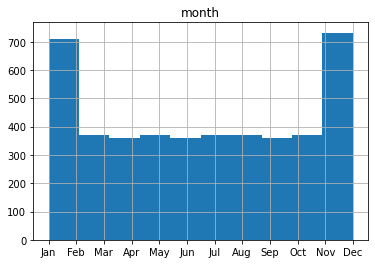

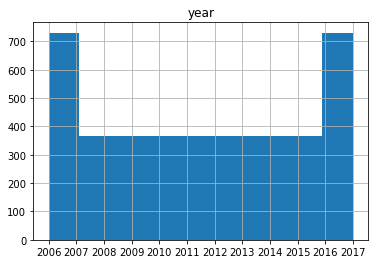

In [166]:
opsd = prepare.prepare(opsd, 'ops')

### Takeaways 
* nothing jumps out
*


## Data Splitting

<AxesSubplot:xlabel='Date'>

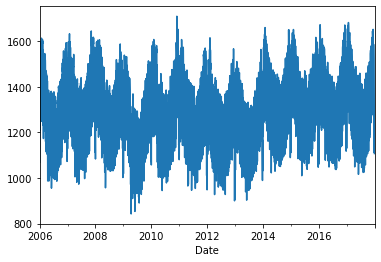

In [168]:
opsd.Consumption.plot()

### Takeaways
* There are regular dips and climbs in consumption. Shows seasonality
* seems flat over time
* will use human-based split

In [174]:
test_opsd = opsd.loc['2017']

In [175]:
train_opsd = opsd.loc[:'2016']

<AxesSubplot:xlabel='Date'>

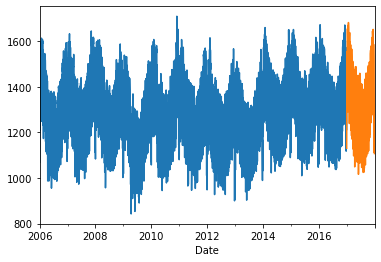

In [178]:
train_opsd.Consumption.plot()
test_opsd.Consumption.plot()

### Takeaways 
* no major problems

## Visualizations - Non-Time Series

In [179]:
y_power = train_opsd.Consumption
y_power.head()

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

<AxesSubplot:ylabel='Frequency'>

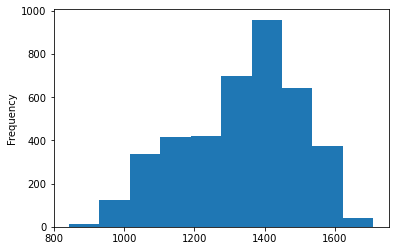

In [180]:
y_power.plot.hist()

[Text(0.5, 1.0, 'Average Consumption by Month')]

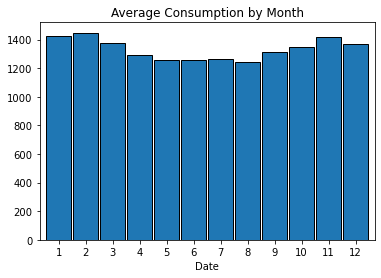

In [183]:
ax = y_power.groupby(y_power.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title= 'Average Consumption by Month')

[Text(0.5, 1.0, 'Average Consumption by Month')]

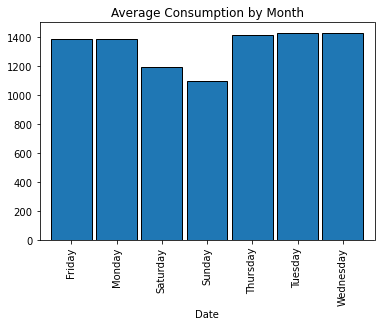

In [185]:
ax = y_power.groupby(y_power.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title= 'Average Consumption by Month')

### Takeaways
* Dips in consumption during the Summer
* Dips in consupmtion over the weekends

## Target Over time

<AxesSubplot:xlabel='Date'>

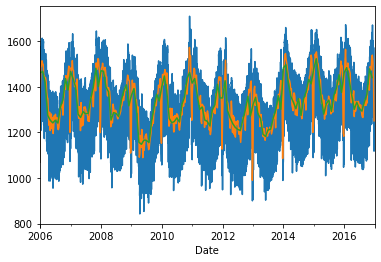

In [193]:
y_power.resample('D').mean().plot()
y_power.resample('W').mean().plot()
y_power.resample('M').mean().plot()


### Takeaways
* Increasing sample range of time smooths out plot

## Changes over time

<AxesSubplot:title={'center':'Average week-to-week change in consumption'}, xlabel='Date'>

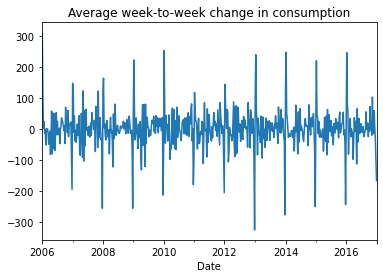

In [197]:
y_power.resample('W').mean().diff()\
    .plot(title='Average week-to-week change in consumption')

<AxesSubplot:title={'center':'Average month-to-month change in consumption'}, xlabel='Date'>

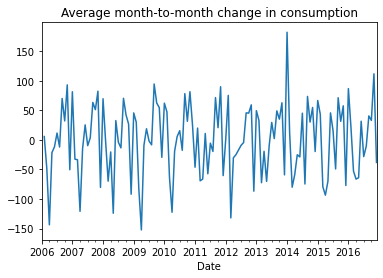

In [199]:
y_power.resample('M').mean().diff()\
    .plot(title='Average month-to-month change in consumption')

### Takeaways 
* The shifts get more extreme towards that later parts of the year
* THe largests negative shifts are during the spring

## Seasonal Plot

<AxesSubplot:title={'center':'Seasonal'}, xlabel='Date'>

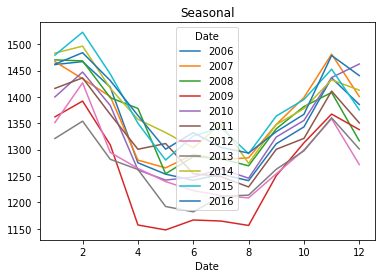

In [201]:
y_power.groupby([y_power.index.year, y_power.index.month]).mean()\
    .unstack(0)\
    .plot(title='Seasonal')

## Seasonal Subseries Plot

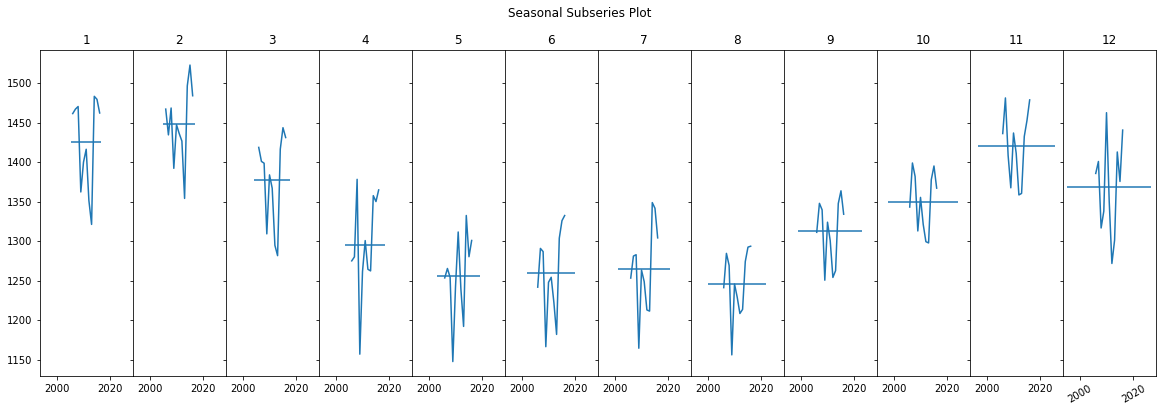

In [206]:
table_power = y_power.groupby([y_power.index.year, y_power.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table_power.items()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    plt.xticks(rotation=30)


fig.suptitle('Seasonal Subseries Plot')
fig.subplots_adjust(wspace=0)
fig.set_size_inches(20,6)

## Lag Plot

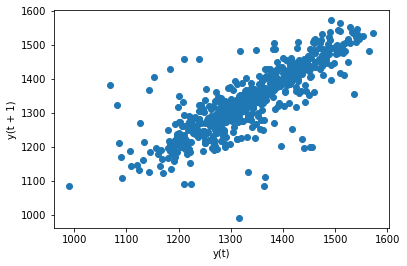

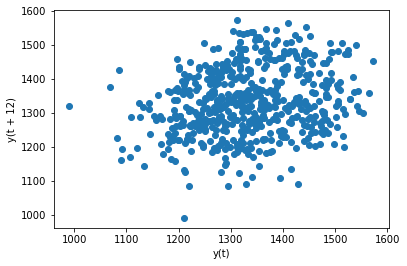

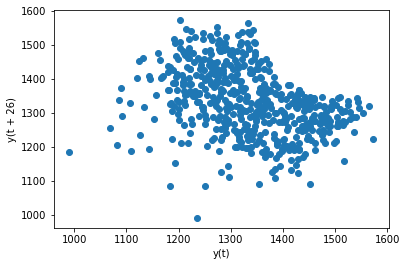

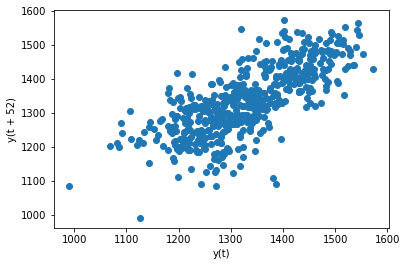

In [210]:
for time_lag in [1, 12, 26, 52]:
    pd.plotting.lag_plot(y_power.resample('W').mean(), lag=time_lag)
    plt.show()

## Autocorrelation Plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

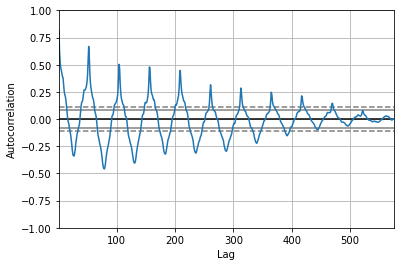

In [212]:
pd.plotting.autocorrelation_plot(y_power.resample('W').mean())

## Seasonal Decomposition

In [216]:
opsd_weekly = train_opsd.Consumption.resample('W').mean()

result = sm.tsa.seasonal_decompose(opsd_weekly)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal, 
    'resid': result.resid,
})

decomposition.head()

,y,trend,seasonal,resid
Date,,,,
2006-01-01,1069.184000,NaN,-33.536583,NaN
2006-01-08,1381.300143,NaN,-151.128130,NaN
2006-01-15,1486.730286,NaN,-23.125938,NaN
2006-01-22,1490.031143,NaN,97.415793,NaN
2006-01-29,1514.176857,NaN,125.755815,NaN


<AxesSubplot:xlabel='Date'>

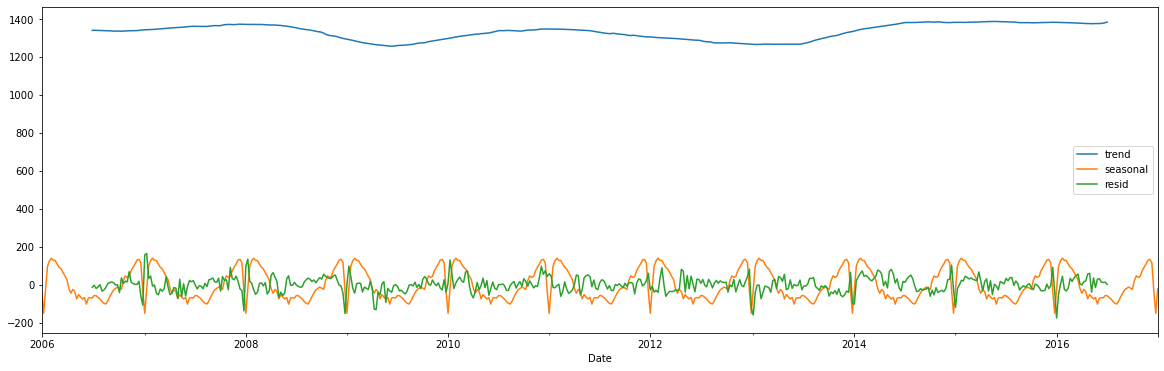

In [218]:
decomposition.iloc[:, 1:].plot(figsize=(20,6))

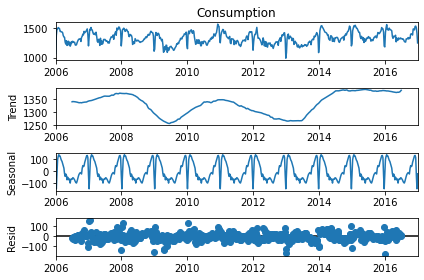

In [220]:
result.plot()
None

## Categories Over Time 

In [223]:
train_opsd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2006-01-01 to 2016-12-31
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4018 non-null   float64
 1   Wind         4018 non-null   float64
 2   Solar        4018 non-null   float64
 3   Wind+Solar   4018 non-null   float64
 4   month        4018 non-null   object 
 5   year         4018 non-null   object 
dtypes: float64(4), object(2)
memory usage: 219.7+ KB


In [282]:
#train_opsd = train_opsd.drop(columns=['Wind', 'Solar', 'Wind+Solar', 'usage'])


In [283]:
train_opsd = train_opsd.resample('D').mean()

In [284]:
train_opsd['usage'] = pd.qcut(train_opsd.Consumption, 3,\
                            labels=['low', 'med', 'high'])

In [291]:
train_opsd.groupby('usage').mean()

,Consumption
usage,
low,1137.833683
med,1360.614938
high,1505.690277


In [292]:
train_opsd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2006-01-01 to 2016-12-31
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Consumption  4018 non-null   float64 
 1   usage        4018 non-null   category
dtypes: category(1), float64(1)
memory usage: 66.8 KB


In [297]:
train_opsd.groupby('usage').mean(0)

,Consumption
usage,
low,1137.833683
med,1360.614938
high,1505.690277


In [300]:
train_opsd.groupby(['usage', train_opsd.index.month]).size()

usage  Date
low    1        79
       2        56
       3        86
       4       128
       5       150
       6       144
       7       140
       8       157
       9        95
       10      106
       11       77
       12      122
med    1        62
       2        50
       3        93
       4       113
       5       150
       6       168
       7       178
       8       182
       9       169
       10       82
       11       37
       12       55
high   1       200
       2       205
       3       162
       4        89
       5        41
       6        18
       7        23
       8         2
       9        66
       10      153
       11      216
       12      164
dtype: int64

<AxesSubplot:xlabel='Date'>

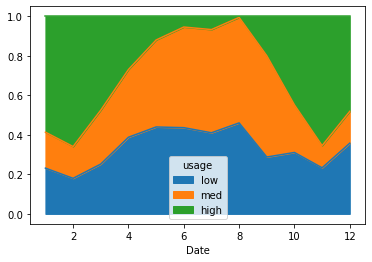

In [302]:
(train_opsd.groupby(['usage', train_opsd.index.month])
.size()
.unstack(0)
.apply(lambda row: row / row.sum(), axis=1)
.plot.area()
)

## Takeaways
* something is wrong with the way resampling outputs with the groupby for this section.

In [303]:

# ax = (consumption.groupby('usage')
# .resample('M')
# .size()
# .unstack(0)
# .apply(lambda row: row / row.sum(), axis=1)
# .plot.area()
# )
# plt.ylabel('% of days in the month')

# ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
# ax.yaxis.set_major_formatter('{:.0%}'.format)

Do your work for this exercise in a notebook named explore. Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.